# W1-C2 Preparing Time Series from Wide-Form Data

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticks

import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split



from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)
import statsmodels.tsa.api as tsa
import warnings
#set_config(transform_output="pandas")
plt.rcParams["figure.figsize"] = (12, 4)
sns.set_context("talk", font_scale=0.9)

# set random seed
SEED = 321
np.random.seed(SEED)

warnings.filterwarnings('ignore')

In [2]:
def thousands(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000
    return f"${new_x:,.0f}K"

In [3]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQN3Ksa9szQuO4G1-msXWAp17KtVHQCBnuEieu_auu1wSiBf3-krHusIx5VBMkihxj-KZLBosDIGEyR/pub?output=csv'

original_df = pd.read_csv(url)

In [4]:
df = original_df;

In [5]:
df.shape

(22467, 281)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22467 entries, 0 to 22466
Columns: 281 entries, RegionID to 2022-09-30
dtypes: float64(273), int64(2), object(6)
memory usage: 48.2+ MB


In [7]:
df = df.loc[df['SizeRank'] < 4]


# how do we know the indexes are the same as the SizeRank? does it come from the API?  edit: do we know this?

In [8]:
df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0


In [9]:
df.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName', '2000-01-31', '2000-02-29',
       ...
       '2021-12-31', '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
       '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30'],
      dtype='object', length=281)

In [10]:
id_vars = df.columns[:8]

In [11]:
melted = df.melt(id_vars=id_vars, var_name='datetime', value_name='HouseValue')

In [12]:
melted

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,datetime,HouseValue
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-01-31,253690.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2000-01-31,234181.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2000-01-31,109068.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2000-01-31,166139.0
4,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-02-29,255517.0
...,...,...,...,...,...,...,...,...,...,...
1087,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2022-08-31,315587.0
1088,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2022-09-30,781622.0
1089,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2022-09-30,966595.0
1090,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2022-09-30,272639.0


In [13]:
melted.datetime = pd.to_datetime(melted.datetime)
melted = melted.set_index('datetime')

In [14]:
melted.index

DatetimeIndex(['2000-01-31', '2000-01-31', '2000-01-31', '2000-01-31',
               '2000-02-29', '2000-02-29', '2000-02-29', '2000-02-29',
               '2000-03-31', '2000-03-31',
               ...
               '2022-07-31', '2022-07-31', '2022-08-31', '2022-08-31',
               '2022-08-31', '2022-08-31', '2022-09-30', '2022-09-30',
               '2022-09-30', '2022-09-30'],
              dtype='datetime64[ns]', name='datetime', length=1092, freq=None)

In [15]:
ts = melted.groupby('RegionName').resample('M')['HouseValue'].mean()
ts = pd.DataFrame(ts)

In [16]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1092 entries, ('Chicago', Timestamp('2000-01-31 00:00:00', freq='M')) to ('New York', Timestamp('2022-09-30 00:00:00', freq='M'))
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   HouseValue  1087 non-null   float64
dtypes: float64(1)
memory usage: 22.3+ KB


In [17]:
ts.unstack().T.columns

Index(['Chicago', 'Houston', 'Los Angeles', 'New York'], dtype='object', name='RegionName')

In [18]:
ts.head()

HouseValue
RegionName datetime              
Chicago    2000-01-31    166139.0
           2000-02-29    166536.0
           2000-03-31    167368.0
           2000-04-30    168826.0
           2000-05-31    170499.0

In [19]:
unstacked = ts.unstack(0)[['HouseValue']]

<Axes: xlabel='Date', ylabel='Home Value'>

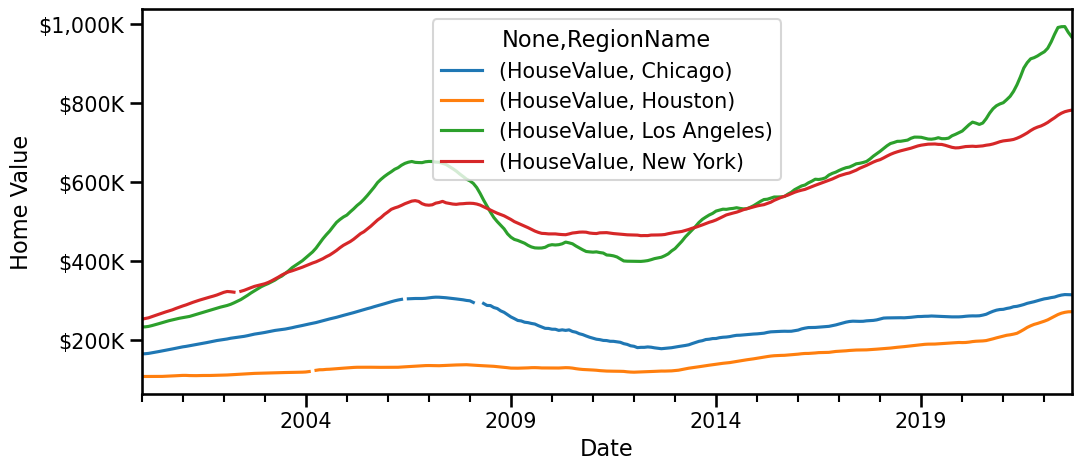

In [20]:
fig, ax = plt.subplots(figsize=(12,5))

fmt_thous = mticks.FuncFormatter(thousands)
ax.set(ylabel='Home Value')

ax.yaxis.set_major_formatter(fmt_thous)
unstacked.plot(ax=ax, xlabel='Date')

## Questions

### 1) Which City had the highest Typical Home Value at the end of 2008? Which had the least?
Answer:
  * Most: New York
  * Least: Houston

### 2) How much did the home values change from November 2008 to December 2008 (in dollars)?

In [21]:
unstacked.head()

HouseValue                                
RegionName    Chicago   Houston Los Angeles  New York
datetime                                             
2000-01-31   166139.0  109068.0    234181.0  253690.0
2000-02-29   166536.0  109079.0    234401.0  255517.0
2000-03-31   167368.0  108878.0    235513.0  257207.0
2000-04-30   168826.0  108881.0    237589.0  260310.0
2000-05-31   170499.0  108834.0    240113.0  263204.0

In [22]:
# unstacked.loc['2008-11']
unstacked.loc['2008-12']

HouseValue                                
RegionName    Chicago   Houston Los Angeles  New York
datetime                                             
2008-12-31   265306.0  131283.0    469294.0  510309.0

In [23]:
unstacked.loc['2008-11':'2008-12']

HouseValue                                
RegionName    Chicago   Houston Los Angeles  New York
datetime                                             
2008-11-30   271059.0  132247.0    481905.0  514767.0
2008-12-31   265306.0  131283.0    469294.0  510309.0

In [24]:
unstacked.loc['2008-11':'2008-12'].diff()

HouseValue                             
RegionName    Chicago Houston Los Angeles New York
datetime                                          
2008-11-30        NaN     NaN         NaN      NaN
2008-12-31    -5753.0  -964.0    -12611.0  -4458.0

In [25]:
ts_part1 = ts.copy()
unstacked_part1 = unstacked.copy()

Answer:

* Chicago: \$-5753
* Houston: \$-964
* LosAngeles: \$-12611
* New York: \$-4458

# W2-C2 Time Series Models for Home Values

* Your overall goal is to forecast the home values for the city with the highest home value in 2008 (New York) 6 months into the future (beyond the dataset).

## Custom Functions

In [26]:
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, icbest) = tsa.adfuller(ts, **kwargs)
    
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {
        "Test Statistic": test_stat,
        "# of Lags Used": nlags,
        "# of Observations": nobs,
        "p-value": round(pval, 6),
        "alpha": alpha,
        "sig/stationary?": pval < alpha,
    }
    
    return pd.DataFrame(adfuller_results, index=[label])

In [27]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                  acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                  seas_color='black'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    # Sig lags line style
    sig_vline_kwargs = dict(ls=":", lw=1, zorder=0, color="red")

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)

    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts, nlags=nlags, alpha=alpha, type="ACF")
        for lag in sig_acf_lags:
            axes[0].axvline(lag, label="sig", **sig_vline_kwargs)

    # PACF
    tsa.graphics.plot_pacf(ts, ax=axes[1], lags=nlags, **pacf_kws)

    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts, nlags=nlags, alpha=alpha, type="PACF")
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label="sig", **sig_vline_kwargs)

    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags // m

        # Seasonal Lines style
        seas_vline_kwargs = dict(ls="--", lw=1, alpha=0.7, color=seas_color, zorder=-1)

        ## for each season, add a line
        for i in range(1, n_seasons + 1):
            axes[0].axvline(m * i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m * i, **seas_vline_kwargs, label="season")

    fig.tight_layout()

    return fig

In [28]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    
### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags == None:
        n_train_lags = len(ts_train)

    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df["mean"].plot(ax=ax, color="green", label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(
        forecast_df.index,
        forecast_df["mean_ci_lower"],
        forecast_df["mean_ci_upper"],
        color="green",
        alpha=0.3,
        lw=2,
    )

    # set the title and add legend
    ax.set_title(title)
    ax.legend()

    return fig, ax
# Custom function for Ad Fuller Test

In [29]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

## Prepare the Data

In [30]:
# Filter the dataset only to include values starting in 2018
# Check for and address null values.
ts = unstacked.loc['2018':].copy()
ts.isna().sum()

            RegionName 
HouseValue  Chicago        0
            Houston        0
            Los Angeles    0
            New York       0
dtype: int64

In [31]:
ts.head()

HouseValue                                
RegionName    Chicago   Houston Los Angeles  New York
datetime                                             
2018-01-31   254397.0  178763.0    677868.0  656700.0
2018-02-28   256564.0  179315.0    684769.0  661012.0
2018-03-31   256995.0  179901.0    691712.0  665672.0
2018-04-30   257112.0  180859.0    697356.0  669989.0
2018-05-31   257174.0  181862.0    699877.0  673514.0

In [32]:
ts.shape

(57, 4)

In [33]:
ts.index

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
      

In [34]:
ts.columns

MultiIndex([('HouseValue',     'Chicago'),
            ('HouseValue',     'Houston'),
            ('HouseValue', 'Los Angeles'),
            ('HouseValue',    'New York')],
           names=[None, 'RegionName'])

In [35]:
ts = ts[[ts.columns[3]]]

In [36]:
ts.index

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
      

In [37]:
ts.reset_index([0]).columns

MultiIndex([(  'datetime',         ''),
            ('HouseValue', 'New York')],
           names=[None, 'RegionName'])

## Detect Seasonality

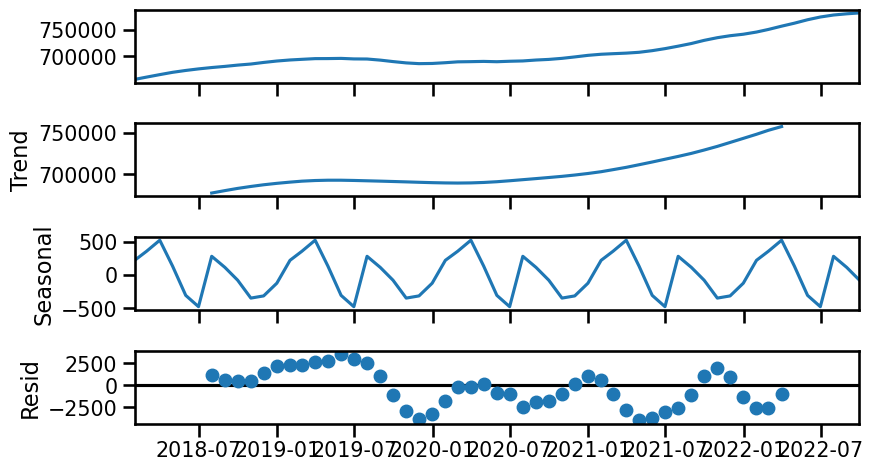

In [38]:
# Decompose the Time series to detect seasonality and decide if your model should or should not have a seasonal component
decomp = tsa.seasonal_decompose(ts)
fig = decomp.plot()
fig.set_size_inches(9, 5)
fig.tight_layout()

In [39]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(ts.values.max()-ts.values.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 1006.1319444442925 which is ~0.81% of the variation in time series.


Let's just do a regular model

## Check for Stationarity and Diffs

In [40]:
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,0.407572,4,52,0.981776,0.05,False


In [41]:
d = ndiffs(ts)
print(f'd is {d}')

d is 2


## Determine Model Orders

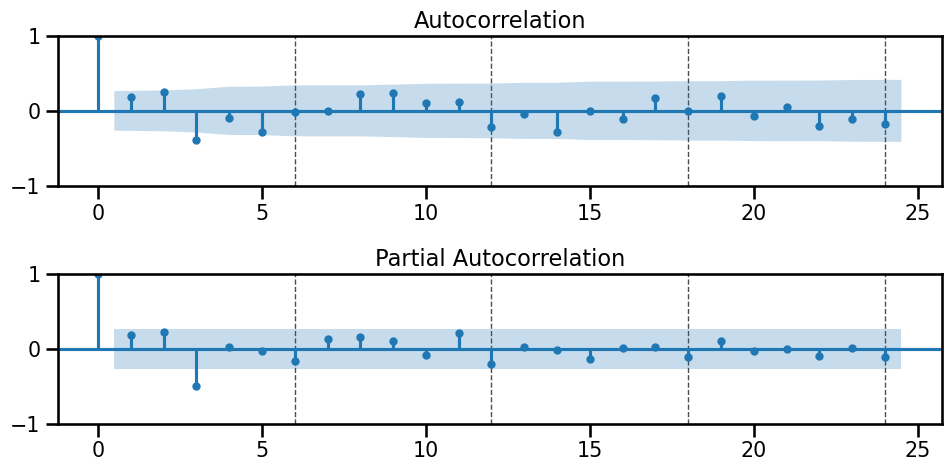

In [42]:
ts_diff2 = ts.diff().dropna().diff().dropna()

plot_acf_pacf(ts_diff2, annotate_seas=True, m = 6, nlags=24);

* Looks like two sharpish drops after lag 1 to me

In [43]:
try_order = (1, 2, 1)

## Train/Test Split

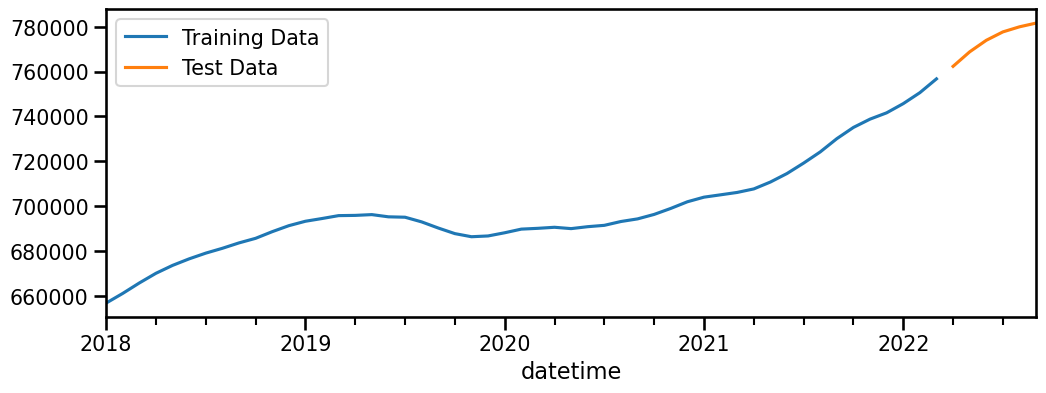

In [44]:
train, test = train_test_split(ts, test_size=6)

## Visualize train-test-split
ax = train.plot(label="train")
test.plot(ax=ax, label="test")
ax.legend(['Training Data', 'Test Data'])

## Fit Manual Model

In [45]:
manual_arima = tsa.ARIMA(train, order=try_order).fit()

In [46]:
manual_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     HouseValue_New York   No. Observations:                   51
Model:                  ARIMA(1, 2, 1)   Log Likelihood                -401.735
Date:                 Sun, 28 Jan 2024   AIC                            809.469
Time:                         18:32:13   BIC                            815.145
Sample:                     01-31-2018   HQIC                           811.623
                          - 03-31-2022                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9337      0.146     -6.378      0.000      -1.221      -0.647
ma.L1          0.9327      0.148      6.294      0.000       0.642       1.223
sigma2      7.754e+05   5.11e-09   1.52e+14      0.000    7.75e+05    7.75e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.63   Jarque-Bera (JB):                 1.79
Prob(Q):                              0.20   Prob(JB):                         0.41
Heteroskedasticity (H):               2.30   Skew:                            -0.01
Prob(H) (two-sided):                  0.11   Kurtosis:                         2.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.65e+31. Standard errors may be unstable.
"""

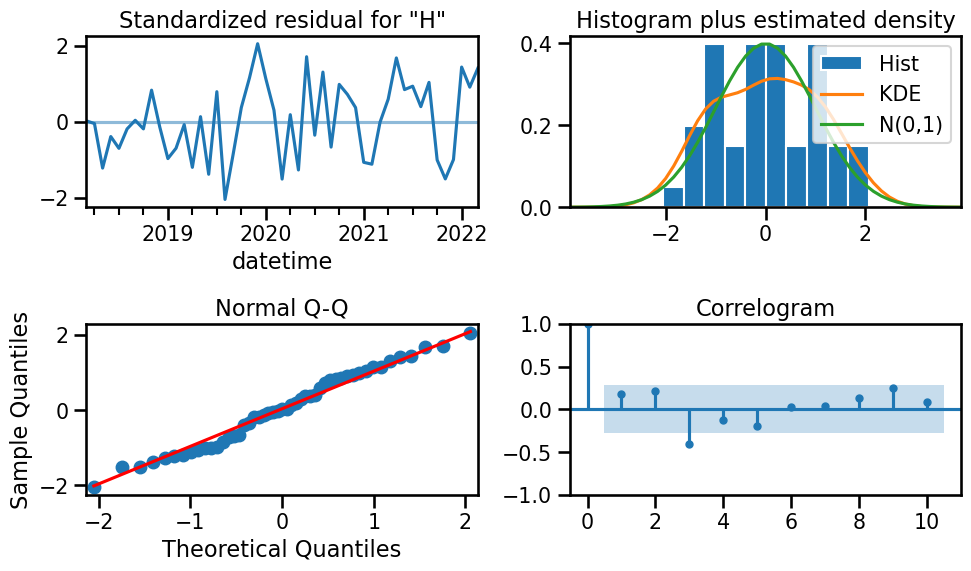

In [47]:
# Obtain diagnostic plots
fig = manual_arima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

### Make forecasts with your model

In [48]:
# Obtain summary of forecast as dataframe
forecast_df = manual_arima.get_forecast(len(test)).summary_frame()
forecast_df

HouseValue_New York,mean,mean_se,mean_ci_lower,mean_ci_upper
2022-04-30,762877.036707,880.586037,761151.119789,764602.953626
2022-05-31,769032.177837,1968.263105,765174.453038,772889.902636
2022-06-30,775176.016511,3293.628459,768720.623353,781631.409669
2022-07-31,781330.408807,4821.044779,771881.334673,790779.482941
2022-08-31,787474.946702,6527.769565,774680.753455,800269.139948
2022-09-30,793628.686103,8396.386679,777172.070612,810085.301594


### Plot the forecasts versus the test data

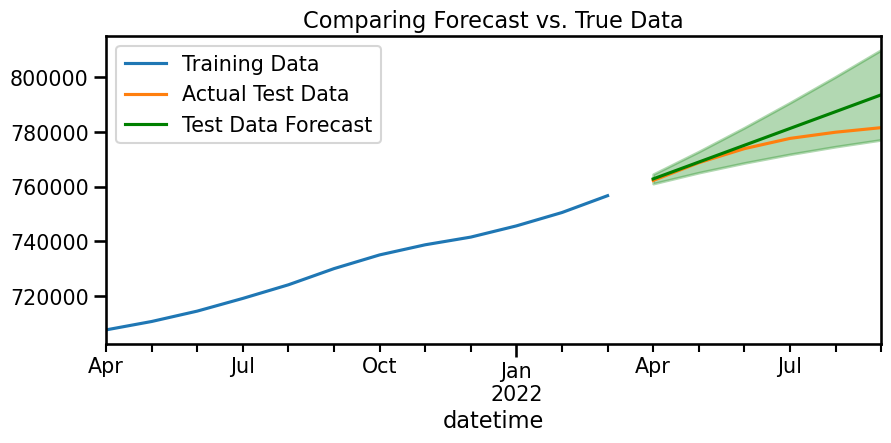

In [49]:
# Plot the forecast with true values
plot_forecast(train, test, forecast_df, n_train_lags = 12)
plt.legend(['Training Data', 'Actual Test Data', 'Test Data Forecast']);

### Obtain metrics for evaluation

In [50]:
forecast_df.mean()

HouseValue_New York
mean             778253.212111
mean_se            4314.613104
mean_ci_lower    769796.725820
mean_ci_upper    786709.698402
dtype: float64

In [51]:
regression_metrics_ts(test, forecast_df["mean"])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 4,197.212
- MSE = 35,959,217.313
- RMSE = 5,996.600
- R^2 = 0.203
- MAPE = 0.54%


## Tune with auto_arima

### Use auto_arima

In [52]:
auto_model = pm.auto_arima(
    train,
    seasonal=False,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1036.895, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=909.717, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=928.324, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=910.593, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=940.569, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=907.207, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1034.889, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=908.639, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=913.343, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=926.258, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.867 seconds


### Make forecasts with your model

In [53]:
auto_arima = tsa.ARIMA(train, order=auto_model.order).fit()
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     HouseValue_New York   No. Observations:                   51
Model:                  ARIMA(1, 1, 1)   Log Likelihood                -453.364
Date:                 Sun, 28 Jan 2024   AIC                            912.728
Time:                         18:32:15   BIC                            918.464
Sample:                     01-31-2018   HQIC                           914.913
                          - 03-31-2022                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.008    123.554      0.000       0.984       1.016
ma.L1         -0.9996      0.096    -10.382      0.000      -1.188      -0.811
sigma2      4.781e+06   5.86e-09   8.15e+14      0.000    4.78e+06    4.78e+06
===================================================================================
Ljung-Box (L1) (Q):                  39.13   Jarque-Bera (JB):                 0.51
Prob(Q):                              0.00   Prob(JB):                         0.77
Heteroskedasticity (H):               1.93   Skew:                            -0.20
Prob(H) (two-sided):                  0.19   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.22e+30. Standard errors may be unstable.
"""

In [54]:
# Obtain summary of forecast as dataframe
forecast_df2 = auto_arima.get_forecast(len(test)).summary_frame()
forecast_df2

HouseValue_New York,mean,mean_se,mean_ci_lower,mean_ci_upper
2022-04-30,758944.235679,2189.866935,754652.175354,763236.296003
2022-05-31,761154.438634,3102.242969,755074.154144,767234.723124
2022-06-30,763364.608866,3805.940416,755905.102724,770824.115009
2022-07-31,765574.746376,4402.196037,756946.600691,774202.892061
2022-08-31,767784.851164,4930.147427,758121.939770,777447.762559
2022-09-30,769994.923231,5409.829320,759391.852600,780597.993862


### Plot the forecasts versus the test data

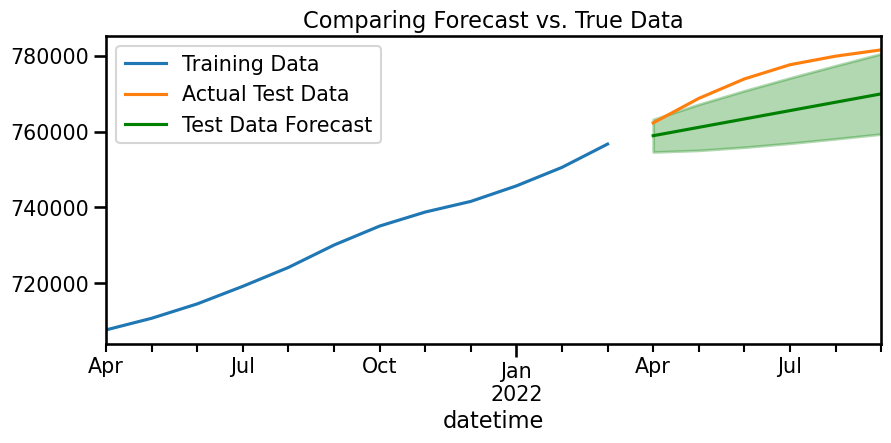

In [55]:
# Plot the forecast with true values
plot_forecast(train, test, forecast_df2, n_train_lags = 12)
plt.legend(['Training Data', 'Actual Test Data', 'Test Data Forecast']);

### Obtain metrics for evaluation

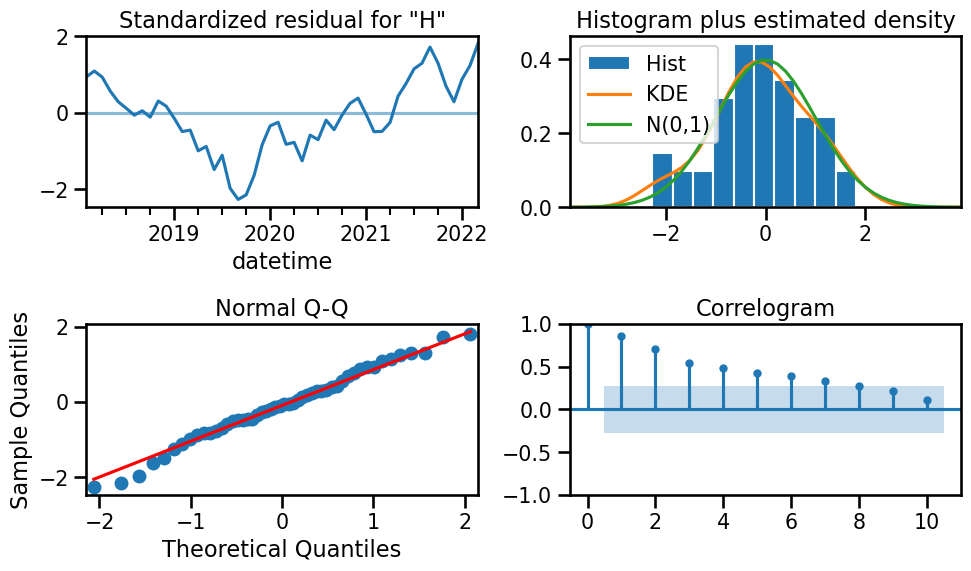

In [56]:
# Obtain diagnostic plots
fig = auto_arima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

In [57]:
regression_metrics_ts(test, forecast_df2["mean"])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 9,586.366
- MSE = 101,997,632.835
- RMSE = 10,099.388
- R^2 = -1.261
- MAPE = 1.24%


* Oof, worse

### Brute force better params

In [58]:
possible_orders = []

for p in range(3):
    for d in range(3):
        for q in range(3):
            model = tsa.ARIMA(train, order=(p,d,q)).fit();
            forecast = model.get_forecast(steps=len(test)).summary_frame();
            metrics = regression_metrics_ts(test, forecast['mean'], output_dict=True, verbose=False);
            if metrics['R^2'] > 0:
                k = str((p, d, q))
                possible_orders.append({
                    k: metrics['R^2']
                })

In [59]:
possible_orders.sort(key=lambda x: list(x.values())[0], reverse=True)
possible_orders

[{'(2, 0, 1)': 0.8455602548761575},
 {'(2, 0, 0)': 0.8385625061089065},
 {'(1, 2, 1)': 0.20297829629812036},
 {'(1, 2, 0)': 0.1977594208584761},
 {'(0, 2, 1)': 0.1977587617117874},
 {'(2, 2, 2)': 0.19683598259161317},
 {'(1, 2, 2)': 0.19644824231331437},
 {'(0, 2, 0)': 0.19607107475315344},
 {'(0, 2, 2)': 0.19393827488402338},
 {'(2, 2, 0)': 0.19382109965709082},
 {'(2, 2, 1)': 0.17175410201387387}]

In [60]:
orders_to_try = [list(order.keys()) for order in possible_orders]

In [61]:
for ord in orders_to_try:
    order = ord[0]
    order = eval(order)
    model = tsa.ARIMA(train, order=order).fit()
    forecast = model.get_forecast(steps=len(test)).summary_frame()
    print(order)
    regression_metrics_ts(test, forecast['mean'], output_dict=True)

(2, 0, 1)
------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 1,778.716
- MSE = 6,967,855.870
- RMSE = 2,639.670
- R^2 = 0.846
- MAPE = 0.23%
(2, 0, 0)
------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 1,823.379
- MSE = 7,283,573.206
- RMSE = 2,698.810
- R^2 = 0.839
- MAPE = 0.23%
(1, 2, 1)
------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 4,197.212
- MSE = 35,959,217.313
- RMSE = 5,996.600
- R^2 = 0.203
- MAPE = 0.54%
(1, 2, 0)
------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 4,217.822
- MSE = 36,194,677.245
- RMSE = 6,016.201
- R^2 = 0.198
- MAPE = 0.54%
(0, 2, 1)
------------------------

## Select Final Model

Somehow (2, 0, 1) had the strongest or second-strongest performance across all metrics

In [62]:
final_order = (2, 0, 1)

In [63]:
final_model = tsa.ARIMA(ts, order=final_order).fit()
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     HouseValue_New York   No. Observations:                   57
Model:                  ARIMA(2, 0, 1)   Log Likelihood                -473.398
Date:                 Sun, 28 Jan 2024   AIC                            956.796
Time:                         18:32:19   BIC                            967.011
Sample:                     01-31-2018   HQIC                           960.766
                          - 09-30-2022                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.065e+05   4.22e+04     16.746      0.000    6.24e+05    7.89e+05
ar.L1          1.9490      0.066     29.476      0.000       1.819       2.079
ar.L2         -0.9524      0.070    -13.583      0.000      -1.090      -0.815
ma.L1          0.1200      0.148      0.811      0.418      -0.170       0.410
sigma2      7.926e+05    132.296   5991.429      0.000    7.92e+05    7.93e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.90
Prob(Q):                              0.89   Prob(JB):                         0.39
Heteroskedasticity (H):               1.85   Skew:                             0.03
Prob(H) (two-sided):                  0.19   Kurtosis:                         2.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.27e+20. Standard errors may be unstable.
"""

### True Future Forecasts

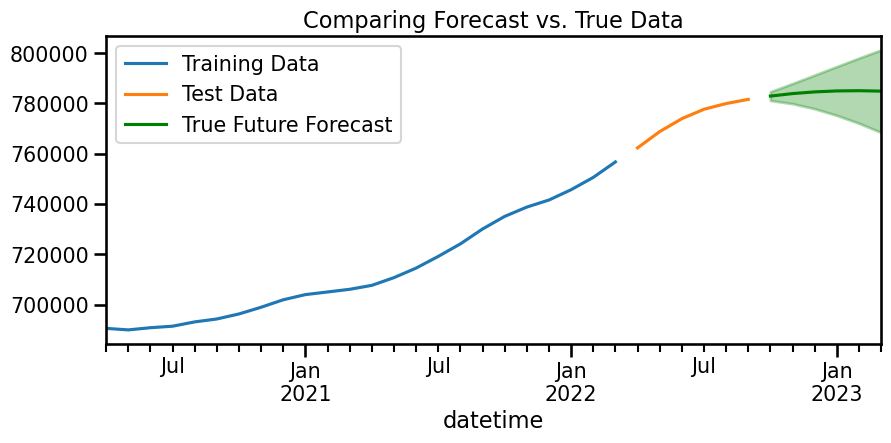

In [64]:
true_forecast = final_model.get_forecast(len(test)).summary_frame()

plot_forecast(train, test, true_forecast, n_train_lags=24)
plt.legend(['Training Data', 'Test Data', 'True Future Forecast']);

#### Raw values for change in the final month in the forecast vs. the first month.

In [65]:
starting_value = true_forecast['mean'].iloc[0]
final_value = true_forecast['mean'].iloc[-1]

delta = final_value - starting_value
print(f'The change in Home Value over the forecast is ${delta:.2f}.')

The change in Home Value over the forecast is $1965.37.


#### Convert the raw delta into a percent change.

In [66]:
perc_change = (delta/starting_value) * 100
print (f'The percentage change is {perc_change :.2f}%.')

The percentage change is 0.25%.


## Questions

* What is the predicted home value in New York City 6 months into the future (beyond the dataset)?
  * **Answer**: $784,898.70

In [67]:
true_forecast.iloc[5].round(2)

HouseValue_New York
mean             784898.70
mean_se            8373.92
mean_ci_lower    768486.11
mean_ci_upper    801311.29
Name: 2023-03-31 00:00:00, dtype: float64

* What is the percent change in home values in New York City by the end of the 6-month forecast (beyond the dataset)?
  * 0.42%

In [69]:
end_of_data = test['HouseValue'].iloc[-1][0]
end_of_forecast = true_forecast['mean'].iloc[-1]

delta = (end_of_forecast - end_of_data)

perc_change = delta / end_of_data * 100
perc_change

0.41921802342869535